<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

import scipy
from scipy.spatial import distance
from scipy import signal

import dynamics
from dynamics import*

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

## Performance analysis
differ by speed, stability and final results on different sizes of arena, both for intra, and extrapolation

In [2]:
class PretrainTest():
    def __init__(self, weight_write, holes = 0, inputs_type = (1, 0)):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_write
            
    def loadweight(self, weight_load):
#       need to take the state dict as a new dict for updating 
        net_dict = torch.load(weight_load)
        list_modules = [('h2h', net_dict['h2h']), ('a2h', net_dict['a2h']), ('i2h', net_dict['i2h']), ('r2h', net_dict['r2h']), ('bh', net_dict['bh'])]
        select_dict = OrderedDict(list_modules)
        net = self.pregame.net.state_dict()
        net.update(select_dict)
        self.pregame.net.load_state_dict(net)
        torch.save(self.pregame.net.state_dict(), self.weight) 
    
        
    def pretrain(self, trial, weight = None, lr = 1e-5, pretrain = True):  
        # start a pretrained game  
        self.pregame.net.cuda()
        if pretrain == True:
            lr = float(lr)
            if weight != None:
                self.pregame.net.load_state_dict(torch.load(weight))
            self.pregame.fulltrain(lr_rate = lr, trials = int(1e3), batchsize = 4)
        print ('pretrain end', torch.norm(self.pregame.net.h2h))
        if pretrain == True:
            torch.save(self.pregame.net.state_dict(), self.weight[:-1]+'{}'.format(trial))
        else:
            torch.save(self.pregame.net.state_dict(), self.weight+'{}'.format(trial))
        if pretrain == True and trial <= 10:
            self.weight = self.weight[:-1]+'{}'.format(trial)
        elif pretrain == True and trial > 10:
            self.weight = self.weight[:-2]+'{}'.format(trial)
        elif pretrain == False:
            self.weight = self.weight +'{}'.format(trial)
            
    def decode(self, weight = None):
        if weight != None:
            self.pregame.net.load_state_dict(torch.load(weight))
        else:
             self.pregame.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl,20, epsilon = 0.5, train_hidden = False, train_q = False, size_range=(15, 16), test = True) 
        def precision():
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0)[0])
            prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
            prec2 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1)[0])
            return (prec0 + prec1 + prec2)/3, (prec2 - prec0)
        print ('decode train finish')
        Prec, dif = precision()
        print ('decode end', Prec, 'dif decode', dif)
        return Prec, dif
        # q learning session 
    
        
    def qlearn(self, weight_read, weight_write, iterations = 5, save = True, size_train = np.arange(10, 51, 10), \
               size_test = [10, 30], train_only = False, test_only = False, noise = 0.3, h2o = True,
              k_action = 1, k_internal = 1, k_stim = 1):
        self.game.net.load_state_dict(torch.load(weight_read))
        if h2o == True:
            self.game.net.h2o = nn.Parameter(torch.randn(512, 4) * 0.01 * np.sqrt(2.0/(512 + 4)))
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        e_rate = [noise for r in range(iterations)] 
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        Rewards = []
        # q leanring phase
        for n,e in enumerate(e_rate):
            prob = np.ones(len(size_train)) 
            prob = prob/np.sum(prob)
            if test_only == False:
                self.game.experiment(rls_q, rls_sl, iterations = 50, epochs= 10, epsilon = e, size_range = size_train)    
                if save == True:
                    torch.save(self.game.net.state_dict(), weight_write + '_{}'.format(n))
            def testing(game):
                Rewards00 = Test(game, reward_control = 0, size = size_test[0], test = 1)
                Rewards01 = Test(game, reward_control = 1, size = size_test[0], test = 1)
                rewards_s = (np.sum(Rewards00) + np.sum(Rewards01))/2
                Rewards10 = Test(game, reward_control = 0, size = size_test[1], test = 2)
                Rewards11 = Test(game, reward_control = 1, size = size_test[1], test = 2)
                rewards_l = (np.sum(Rewards10) + np.sum(Rewards11))/2
                return rewards_s, rewards_l
            # load weight if test only is true 
            if test_only == True:
                self.game.net.load_state_dict(torch.load(weight_write))
            if train_only == False:
                rewards_s, rewards_l = testing(self.game)
            print (n, 'rewards_s',  rewards_s, 'rewards_l', rewards_l)
            Rewards.append((rewards_s, rewards_l))
        return Rewards
    
    def TestAllSizes(self, size_range = np.arange(5, 50, 5), k_action = 1, k_internal = 1, 
                    k_stim = 1, limit_set = 4, test_size = 1):
        self.game.net.load_state_dict(torch.load(self.weight))
        self.game.net.cpu()
        self.Performance = []
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        for size in size_range:
            Rewards0 = Test(self.game, reward_control = 0, size = size, limit_set = limit_set, test = test_size)
            Rewards1 = Test(self.game, reward_control = 1, size = size, limit_set = limit_set, test = test_size)
            self.Performance.append((Rewards0 + Rewards1)/2)

In [4]:
def performance_measure(size, test_size, trials = 3, \
                        shuffle = False, pretrain = False, random = False, k_action = 1, k_internal = 1, k_stim = 1, limit_set = 4):
    performance = np.zeros((trials, 5))
    for iters1 in np.arange(trials):
        for iters2 in np.arange(5, 10):
            if shuffle == True:
                weight = 'weights2_shuffle/rnn_1515tanh512_checkpoint300_{}_{}'.format(iters1, iters2)
            if random == True:
                weight = 'weights_2_random/rnn_1515tanh512_checkpoint300_{}_{}'.format(iters1, iters2)
            if pretrain == True:
                weight = 'weights2/rnn_1515tanh512_checkpoint300_{}_{}'.format(iters1, iters2)
            Pretest = PretrainTest(weight_write = weight)
            Pretest.TestAllSizes(size_range = [size], limit_set = limit_set, test_size = test_size)
            performance[iters1, iters2-5] = Pretest.Performance[0]
    print(np.max(performance, axis = 1))
    return performance
# performance_measure(0, 0, 10, 0)

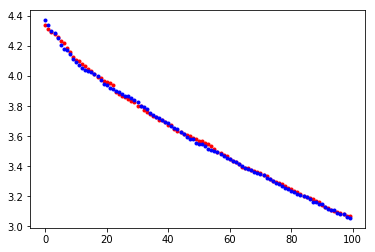

In [8]:
## The rank of pertubation 
Net = torch.load('weights_net1/rnn_1515tanh512_checkpoint39_0_9')
h2h_39 = Net['h2h'].clone()
Net = torch.load('weights_cpu1/rnn_1515tanh512_checkpoint0')
h2h_0 = Net['h2h'].clone()
dW = h2h_39 - h2h_0
dW = dW.data.numpy()
dW_shuffle = np.random.permutation(dW.ravel()).reshape(512, 512)
u, s, vh = np.linalg.svd(dW)
u_shuffle, s_shuffle, vh_shuffle = np.linalg.svd(dW_shuffle)
plt.figure()
plt.plot(s[:100],'r.')
plt.plot(s_shuffle[:100],'b.')

## Learning History

In [17]:
trial = 399

for iters1, noise in enumerate(3 * [0.0]):
    performance = []
    for iters2 in np.arange(11):
        if iters2 == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial))
            Pretest.TestAllSizes(size_range = [10], limit_set = 4, test_size = 0)
            performance.append(Pretest.Performance)
        if iters2>0:
            Pretest = PretrainTest(weight_write = 'weights2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, iters1, iters2-1))
            Pretest.TestAllSizes(size_range = [10], limit_set = 4, test_size = 0)
            performance.append(Pretest.Performance)
    np.save('Rewards_s_{}_{}.npy'.format(iters1, 39), performance)

([<matplotlib.axis.XTick at 0x7f10b4079b70>,
 <a list of 3 Text xticklabel objects>)

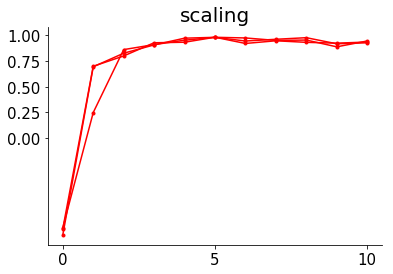

In [19]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
Performance_pos = []
for iters, noise in enumerate(3 * [0.0]):
    for trial in [39]: 
#         reward = np.load('Rewards_s_{}_{}_s.npy'.format(iters, trial))
#         plt.plot(reward, 'c.--')
        reward = np.load('Rewards_s_{}_{}.npy'.format(iters, trial))
        plt.plot(reward, 'r.-')
        Performance_pos.append(reward)
np.save('Performance_pos', Performance_pos)
# plt.xticks([0, 10, 20, 30], size = 15)
# plt.yticks([-0.4, 0, 0.4, 0.8], size = 15)
plt.title('scaling', size = 20)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size = 15)
plt.xticks([0, 5, 10], size = 15)

## Generalization

In [29]:
performance10s = performance_measure(10, 0, trials = 3, k_action=1, k_internal=1, k_stim=1, shuffle = True)

[0.89382289 0.88362879 0.63989213]


In [31]:
performance30s = performance_measure(30, 1, trials = 3, k_action=1, k_internal=1, k_stim=1, shuffle = True)

[0.66994826 0.63774505 0.5900243 ]


In [34]:
performance50s = performance_measure(50, 2, trials = 3, k_action=1, k_internal=1, k_stim=1, limit_set = 4, shuffle = True)

[0.04155628 0.16913799 0.41453743]


In [35]:
performance70s = performance_measure(70, 3, trials = 3, k_action=1, k_internal=1, k_stim=1, limit_set = 4, shuffle = True)

[-0.30221783 -0.34138944  0.14160454]


In [37]:
performance90s = performance_measure(90, 4, trials = 3, k_action=1, k_internal=1, k_stim=1, limit_set = 4, shuffle = True)

[-0.46954419 -0.4601164   0.05965583]


In [38]:
np.save('performance10s', performance10s)
np.save('performance30s', performance30s)
np.save('performance50s', performance50s)
np.save('performance70s', performance70s)
np.save('performance90s', performance90s)

In [5]:
performance10s = np.load('performance10s.npy')
performance30s = np.load('performance30s.npy')
performance50s = np.load('performance50s.npy') 
performance70s = np.load('performance70s.npy') 
performance90s = np.load('performance90s.npy')
performance_g10_s = np.max(performance10s, axis = 1)
performance_g30_s = np.max(performance30s, axis = 1)
performance_g50_s = np.max(performance50s, axis = 1) 
performance_g70_s = np.max(performance70s, axis = 1) 
performance_g90_s = np.max(performance90s, axis = 1)

In [6]:
performance_10 = np.load('performance_10_1.npy')
performance_30 = np.load('performance_30_1.npy')
performance_50 = np.load('performance_50_1.npy') 
performance_70 = np.load('performance_70_1.npy') 
performance_90 = np.load('performance_90_1.npy')
performance_g10 = np.max(performance_10, axis = 1)
performance_g30 = np.max(performance_30, axis = 1)
performance_g50 = np.max(performance_50, axis = 1) 
performance_g70 = np.max(performance_70, axis = 1) 
performance_g90 = np.max(performance_90, axis = 1)

In [7]:
# PG_s = [performance_g10_s, performance_g30_s, performance_g50_s, performance_g70_s, performance_g90_s]
# pG_s = np.concatenate(PG_s)
PGs = [performance_g10_s, performance_g30_s, performance_g50_s, performance_g70_s, performance_g90_s]
PGs = np.concatenate(PGs).reshape(-1, 3)

PG = [performance_g10, performance_g30, performance_g50, performance_g70, performance_g90]
PG = np.concatenate(PG).reshape(-1, 3)

In [64]:
np.mean(PG.reshape(-1, 3), axis = 1)

array([ 0.96773916,  0.28721932, -0.10550769, -0.22726694, -0.35475567])

In [65]:
np.save('PG_Scaling_PosNet', PG)
np.save('PG_Scaling_PosNet_shuffle', PGs)

In [9]:
PG_echo = np.load('PG_echo.npy')

<Container object of 3 artists>

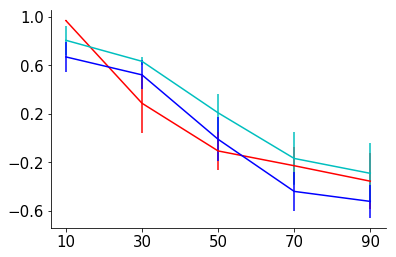

In [10]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([10, 30, 50, 70, 90], size = 15)
plt.yticks([-0.6, -0.2, 0.2, 0.6, 1], size = 15)
plt.errorbar(np.arange(10, 91, 20), np.mean(PG, axis = 1), yerr = np.std(PG, axis = 1), color = 'r')
plt.errorbar(np.arange(10, 91, 20), np.mean(PGs, axis = 1), yerr = np.std(PGs, axis = 1), color = 'c')
plt.errorbar(np.arange(10, 91, 20), np.mean(PG_echo, axis = 1), yerr = np.std(PG_echo, axis = 1), color = 'b')


In [58]:
performance = performance_measure(90, 4, trials = 5, k_action=1, k_internal=1, k_stim=1, limit_set = 16)

[ 0.63905325  0.27810651 -0.00591716 -0.08284024  0.20710059]


In [68]:
np.save('performance90_shuffle', performance)

In [81]:
performance = performance_measure(90, 4, trials = 5, k_action=1, k_internal=1, k_stim=1, limit_set = 16,
                                 pretrain = True)

[ 0.07100592 -0.28994083  0.3964497   0.18343195 -0.25443787]


In [82]:
np.save('performance90', performance)

In [83]:
performance = performance_measure(30, 1, trials = 5, k_action=1, k_internal=1, k_stim=1, pretrain = True)

[0.76 0.28 0.58 0.74 0.52]


In [84]:
np.save('performance30', performance)

### Performance 30 as reference

In [77]:
perform30 = np.load('performance30_shuffle.npy')
np.mean(perform30[perform30>0.0]) 

0.6187999999999999

In [85]:
perform30 = np.load('performance30.npy')
np.mean(perform30[perform30>0.0]) 

0.45875

### Performance 90 as test

In [78]:
perform90 = np.load('performance90_shuffle.npy')
np.mean(perform90[perform30>0.3])

-0.08001029071263185

In [86]:
perform90 = np.load('performance90.npy')
np.mean(perform90[perform30>0.3])

-0.1643655489809336

## GLM

In [81]:

def variance_decompose(pca, T, open_loop = True, alpha = 1e-4):
    Actions = np.zeros((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    Y = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    X = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    Stims = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    colors = ['b', 'g', 'r', 'm']
    for i in range(pca.Hiddens.shape[0]):
        for j in range(pca.Hiddens.shape[1]):
            if open_loop == False:
                Actions[i, j] = pca.Actions[i, j, :T]
            else:
                Actions[i, j] = j
            Stims[i, j] = i
            Y[i, j] = pca.Ys[i, j, :T]
            X[i, j] = pca.Xs[i, j, :T]

    x =  pca.Hiddens[:, :, :T, :].reshape(-1, 512)
    z = (x - np.min(x))/(np.max(x) - np.min(x))
    y = np.log(z/(1-z + 1e-3) + 1e-3)
     ## features:
    A = np.array([np.eye(4)[int(a)] for a in Actions.reshape(-1)]).reshape(-1, 4)
    S = np.array([np.eye(4)[int(s)] for s in Stims.reshape(-1)]).reshape(-1, 4)
    Y = Y.reshape(-1, 1)/np.max(np.abs(Y))
    X = X.reshape(-1, 1)/np.max(np.abs(X))
    Features = np.concatenate((A, S, Y, X), axis = 1)
    Features_A = np.concatenate((S, Y, X), axis = 1)
    Features_S = np.concatenate((A, Y, X), axis = 1)
    Features_Y = np.concatenate((A, S, X), axis = 1)
    Features_X = np.concatenate((A, S, Y), axis = 1)

    clf1 = Lasso(alpha = alpha)
    clf1.fit(Features, y)
    y_pred = clf1.predict(Features)
    Importances = []
    importances = []
    for feature in [Features_A, Features_S, Features_Y, Features_X]:
        clf = Lasso(alpha= alpha)
        clf.fit(feature, y)
        y_pred_i = clf.predict(feature)
#         print (r2_score(y, y_pred_i), r2_score(y, y_pred))
        importances.append(r2_score(y, y_pred) - r2_score(y, y_pred_i))
        Importance = []
        for i in range(512):
            dif =  r2_score(y[:, i], y_pred[:, i]) - r2_score(y[:, i], y_pred_i[:, i])
            if dif<0:
                dif = 0
            Importance.append(dif)
        Importances.append(Importance)
    return importances

def Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, epsilon = 1, context_gain = 1, shuffle = False):
    # reference from net 1 
    def placefield(pos): 
        field =np.zeros((2, 19))
        for k in range(2):
            for i in range(field.shape[1]): 
            # distance generation 
                pos_relative = pos[k]
                field[k, i] =  (i- pos_relative) ** 2 
        field = - 0.1 * torch.from_numpy(field).resize(1, 2 * 19).float()
        return field
    Info_P = np.zeros(5)
    Info_I = np.zeros(5)
    Info_A = np.zeros(5)
    pca = PCA(weight = weight)
    pca.pca(T_duration = 3, shuffle = shuffle)
    pca.game.net.k_action = k_action
    pca.game.net.k_internal = k_internal
    pca.game.net.k_stim = k_stim
    for pos_reward in [(9, 5), (9, 13)]:
        context = context_gain * placefield(pos_reward)
        pca.Dynamics(Actions = 10 * [0], legend = True, T_total = 200, T_stim = 30, T_duration = 2, \
                     readout_random = True, open_loop = False, e = epsilon, context = context)
        for i in range(2):
            T = 20 + i * 40
            importances = variance_decompose(pca, T, open_loop=False)
            Info_A[i] += importances[0]
            Info_I[i] += importances[1]
            Info_P[i] += importances[2] + importances[3]  
    Info_A = Info_A/2    
    Info_P = Info_P/2  
    Info_I = Info_I/2  
    print (np.mean(Info_A), np.mean(Info_I), np.mean(Info_P))
    return Info_A, Info_I, Info_P 


In [82]:
Infos_I_echo = []
Infos_P_echo = []
Decay_echo = []
for i in range(5):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint0'
    Info_A_pre, Info_I_pre, Info_P_pre  = Memory(weight)
    Infos_I_echo.append(Info_I_pre[0])
    Infos_P_echo.append(np.mean(Info_P_pre))
    Decay_echo.append(Info_I_pre[-1]/Info_I_pre[0])

0.0009806767845344899 0.03325936374254192 0.005272873362531587
0.0010129733066417581 0.033704163693452575 0.004334576937217811
0.0008487824905847013 0.03390596678911339 0.005436470960863353
0.0009418417043063371 0.03684539257875271 0.0045978295593018265
0.0010528428792267812 0.02866286515148251 0.005735939261711727


In [59]:
Infos_I_pre1 = []
Infos_P_pre1 = []
Decay1 = []
for i in range(5):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint300'
    Info_A_pre, Info_I_pre, Info_P_pre  = Memory(weight)
    Infos_I_pre1.append(Info_I_pre[0])
    Infos_P_pre1.append(np.mean(Info_P_pre))
    Decay1.append(Info_I_pre[-1]/Info_I_pre[0])

0.0072990368639409 0.1729895019150659 0.24260646371925326
0.008346171706992908 0.18365971300795442 0.27319088621041
0.008303657220661703 0.1525216214653469 0.28045182734268037
0.007198782369610773 0.16845257853785991 0.2659407594646659
0.008543717361823772 0.15990268651300218 0.2695898384046197


In [80]:
Infos_I_pre1s = []
Infos_P_pre1s = []
Decay1s = []
for i in range(5):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint300'
    Info_A_pre, Info_I_pre, Info_P_pre  = Memory(weight, shuffle = True)
    Infos_I_pre1s.append(Info_I_pre[0])
    Infos_P_pre1s.append(np.mean(Info_P_pre))
    Decay1s.append(Info_I_pre[-1]/Info_I_pre[0])
    print ('decay', Info_I_pre)

0.0017804786292199726 0.05117631257092593 0.018513293824991933
decay [0.10014294 0.06041809 0.03981417 0.03102742 0.02447894]
0.002457124870230956 0.03859591485775725 0.02568724291946184
decay [0.08801462 0.03905116 0.02748655 0.02145755 0.01696971]
0.0018640547697918084 0.032199011150832305 0.0284397688539595
decay [0.09238944 0.03338036 0.01693204 0.01081364 0.00747957]
0.001699162600359888 0.04165743855105987 0.04192333200030145
decay [0.08629969 0.04824998 0.03185256 0.0231373  0.01874765]
0.0022524786336395306 0.04136796719515334 0.039997289422097695
decay [0.09731481 0.04876652 0.02867858 0.0185888  0.01349112]


In [61]:
np.save('infos_I_pre1', Infos_I_pre1)
np.save('infos_p_pre1', Infos_P_pre1)
np.save('decay_pre1', Decay1)
np.save('infos_I_pre1_shuffle', Infos_I_pre1s)
np.save('infos_p_pre1_shuffle', Infos_P_pre1s)
np.save('decay_pre1_shuffle', Decay1s)

In [62]:
np.save('infos_I_echo', Infos_I_echo)
np.save('infos_p_echo', Infos_P_echo)
np.save('decay_echo', Decay_echo)

In [10]:
Infos_I_pre1 = np.load('infos_I_pre1.npy')
Infos_P_pre1 = np.load('infos_p_pre1.npy')
Decays_pre1 = np.load('decay_pre1.npy')
Infos_I_pre1s = np.load('infos_I_pre1_shuffle.npy')
Infos_P_pre1s = np.load('infos_p_pre1_shuffle.npy')
Decays_pre1s = np.load('decay_pre1_shuffle.npy')

In [14]:

Infos_I_pre2 = np.load('infos_I_pre2.npy')
Infos_P_pre2 = np.load('infos_p_pre2.npy')
Decays_pre2 = np.load('decay_pre2.npy')
Infos_I_pre2s = np.load('infos_I_pre2_shuffle.npy')
Infos_P_pre2s = np.load('infos_p_pre2_shuffle.npy')
Decays_pre2s = np.load('decay_pre2_shuffle.npy')

In [15]:
Infos_I_echo = np.load('infos_I_echo.npy')
Infos_P_echo = np.load('infos_p_echo.npy')
Decays_echo = np.load('decay_echo.npy')

([<matplotlib.axis.YTick at 0x7f95144f44e0>,
 <a list of 3 Text yticklabel objects>)

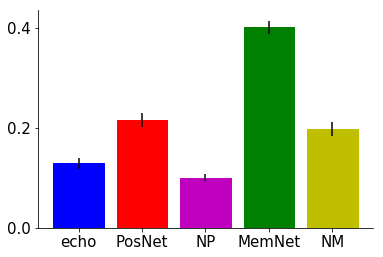

In [17]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
set_stim = [np.mean(Infos_I_echo), np.mean(Infos_I_pre1), np.mean(Infos_I_pre1s), np.mean(Infos_I_pre2), np.mean(Infos_I_pre2s)]
set_std = [np.std(Infos_I_echo), np.std(Infos_I_pre1), np.std(Infos_I_pre1s), np.std(Infos_I_pre2), np.std(Infos_I_pre2s)]
barlist = plt.bar(np.arange(5), height = set_stim, yerr = set_std)
barlist[0].set_color('b')
barlist[1].set_color('r')
barlist[2].set_color('m')
barlist[3].set_color('g')
barlist[4].set_color('y')
plt.xticks([0, 1, 2, 3, 4], ['echo', 'PosNet', 'NP', 'MemNet', 'NM'], size = 15)
plt.yticks([0, 0.2, 0.4], size = 15)

([<matplotlib.axis.YTick at 0x7f95144b1240>,
 <a list of 3 Text yticklabel objects>)

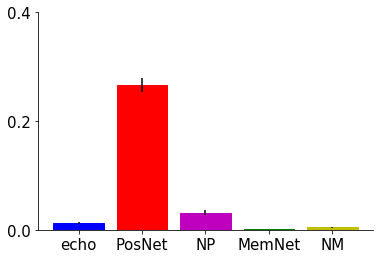

In [18]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
set_stim = [np.mean(Infos_P_echo), np.mean(Infos_P_pre1), np.mean(Infos_P_pre1s), np.mean(Infos_P_pre2), np.mean(Infos_P_pre2s)]
set_std = [np.std(Infos_P_echo), np.std(Infos_P_pre1), np.std(Infos_P_pre1s), np.std(Infos_P_pre2), np.std(Infos_P_pre2s)]
barlist = plt.bar(np.arange(5), height = set_stim, yerr = set_std)
barlist[0].set_color('b')
barlist[1].set_color('r')
barlist[2].set_color('m')
barlist[3].set_color('g')
barlist[4].set_color('y')
plt.xticks([0, 1, 2, 3, 4], ['echo', 'PosNet', 'NP', 'MemNet', 'NM'], size = 15)
plt.yticks([0, 0.2, 0.4], size = 15)

([<matplotlib.axis.YTick at 0x7f95144c1dd8>,
 <a list of 3 Text yticklabel objects>)

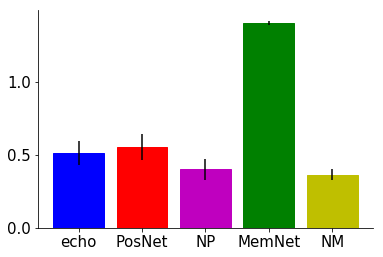

In [19]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
set_stim = [np.mean(Decays_echo), np.mean(Decays_pre1), np.mean(Decays_pre1s), np.mean(Decays_pre2), np.mean(Decays_pre2s)]
set_std = [np.std(Decays_echo), np.std(Decays_pre1), np.std(Decays_pre1s), np.std(Decays_pre2), np.std(Decays_pre2s)]
barlist = plt.bar(np.arange(5), height = set_stim, yerr = set_std)
barlist[0].set_color('b')
barlist[1].set_color('r')
barlist[2].set_color('m')
barlist[3].set_color('g')
barlist[4].set_color('y')
plt.xticks([0, 1, 2, 3, 4], ['echo', 'PosNet', 'NP', 'MemNet', 'NM'], size = 15)
plt.yticks([0, 0.5, 1], size = 15)

## Behaviour 

In [ ]:
torch.manual_seed(np.random.randint(1e5))
hidden = torch.randn(1, 512)
size = 10
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights_net1_shuffle/rnn_1515tanh512_checkpoint39_2_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
   
    if i == 0:
        plt.matshow(grid)
#         y1 = np.array([p[0] for p in Pos1])
#         x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')


size = 90
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight = 'weights_net1_shuffle/rnn_1515tanh512_checkpoint39_2_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

  


# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**